In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Anomaly.estimators import meanEmbeding_MC, var_OMMD_MC, moyenneMMD_MC, puissance_MC, threshold_MC
from Anomaly.kernels import gaussian, laplacian, polynomial, CCK
from Anomaly.utils import normal, inv_phi
from Anomaly.experiments import courbe_ROC
from Anomaly.MMD import OMMD

## Covariance Matrix

### Code

In [3]:
def partial_covarianceOMMD_MC(Kernels, law_p, law_q, size_gen = 100, finalSampleSize=1000, verbose = 1):
    sample = np.zeros((len(Kernels), finalSampleSize))
    for i in range(finalSampleSize):
        if verbose > 0:
            print(i/finalSampleSize*100, '% achevé',end='\r',flush=True)
        x1 = law_p(1)
        x2 = law_p(1)
        for j in range(len(Kernels)):
            sample[j,i] = Kernels[j](x1,x2) -  meanEmbeding_MC(Kernels[j], x1, law_q, size_gen = size_gen) -  meanEmbeding_MC(Kernels[j], x2, law_q, size_gen = size_gen)
    return np.cov(sample)

In [4]:
def cov_OMMD_MC(Kernels, law_p, law_q, size_gen = 100,Lambda = 0.1, finalSampleSize=1000, verbose = 1):
    if verbose > 0:
        print("Start computing first componant")
    first_componant = partial_covarianceOMMD_MC(Kernels, law_p, law_q, size_gen = size_gen, finalSampleSize=finalSampleSize, verbose = verbose)
    if verbose > 0:
        print("Start computing second componant")
    second_componant = partial_covarianceOMMD_MC(Kernels, law_q, law_p, size_gen = size_gen, finalSampleSize=finalSampleSize, verbose = verbose)
    return 2*(first_componant + 1/Lambda*second_componant)

### Validation

In [5]:
kernel1 = gaussian(1)
kernel2 = gaussian(2)
law_p = normal(0,1)
law_q = normal(1,1)

In [6]:
Mp = partial_covarianceOMMD_MC([kernel1, kernel2,kernel1], law_p, law_q, verbose = 0)
print(Mp)

[[0.1439546  0.11570343 0.14112788]
 [0.11570343 0.0996475  0.11509057]
 [0.14112788 0.11509057 0.14223961]]


In [7]:
M = cov_OMMD_MC([kernel1, kernel2,kernel1], law_p, law_q, verbose = 0)
print(M)

[[3.08679407 2.49824599 3.03737519]
 [2.49824599 2.16958791 2.48915246]
 [3.03737519 2.48915246 3.07399163]]


In [8]:
kernel3 = CCK([kernel1,kernel2,kernel1],[1,0.2,0])
var_OMMD_MC(kernel3, law_p, law_q,verbose=0)

4.5200804071066205

In [9]:
beta = np.array([1,0.2,0]).reshape((-1,1))
beta.T.dot(M).dot(beta)

array([[4.17287598]])

### Experiments

In [10]:
law_p = normal(0,1)
law_q = normal(1,1)
Mp = partial_covarianceOMMD_MC([gaussian(1), gaussian(2)], law_p, law_q, verbose = 0)
print(Mp)

[[0.1418053  0.1174166 ]
 [0.1174166  0.10436517]]


In [11]:
Mp = partial_covarianceOMMD_MC([laplacian(1), laplacian(10)], law_p, law_q, verbose = 0)
print(Mp)

[[0.08396116 0.0305535 ]
 [0.0305535  0.02873135]]


In [12]:
Mp = partial_covarianceOMMD_MC([gaussian(1), laplacian(1)], law_p, law_q, verbose = 0)
print(Mp)

[[0.13861177 0.10321068]
 [0.10321068 0.08462447]]


In [13]:
Mp = partial_covarianceOMMD_MC([gaussian(1), polynomial(0,1)], law_p, law_q, verbose = 0)
print(Mp)

[[0.15016113 0.52852067]
 [0.52852067 3.00471452]]


In [14]:
Mp = partial_covarianceOMMD_MC([gaussian(1), polynomial(10,1)], law_p, law_q, verbose = 0)
print(Mp)

[[0.15219403 0.55268032]
 [0.55268032 3.2941323 ]]


## Gradient Descent Algorithm

### Code

In [15]:
def next_step(beta, Snum, Sden, Moy, alpha, m,tr=0.01):
    beta_new = beta - tr*(Snum.dot(beta)/np.sqrt(beta.T.dot(Snum).dot(beta))*inv_phi(1-alpha) - np.sqrt(m)*Moy)
    beta_new = beta_new/np.sqrt(beta_new.T.dot(Sden).dot(beta_new))
    return beta_new

### Validation

In [36]:
law_p = normal(0,1)
law_q = normal(0.5,np.sqrt(.75))
kernel1 = gaussian(1)
kernel2 = polynomial(0,2)

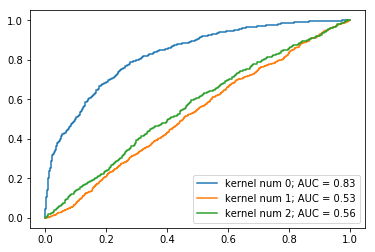

In [37]:
courbe_ROC([kernel1,kernel2,CCK([kernel1,kernel2],[1,1])], law_p, law_q, 1000,100,1000)

In [16]:
Sden = cov_OMMD_MC([kernel1, kernel2], law_p, law_q, verbose = 0)
Sden

array([[3.30563807, 2.65982793],
       [2.65982793, 2.29599467]])

In [17]:
Snum = cov_OMMD_MC([kernel1, kernel2], law_p, law_p, verbose = 0)
Snum

array([[1.65553538, 1.19582456],
       [1.19582456, 0.97970192]])

In [18]:
Moy = np.r_[moyenneMMD_MC(OMMD, kernel1, law_p, law_q, 1000, 100, verbose=0),
           moyenneMMD_MC(OMMD, kernel2, law_p, law_q, 1000, 100, verbose=0)].reshape(-1,1)

In [19]:
Moy

array([[0.16993204],
       [0.15953815]])

In [20]:
beta = np.array([[0],[1]])
for i in range(100):
    print("Step ",i)    
    beta = next_step(beta, Snum, Sden, Moy, tr=0.01, alpha=0.05,m=1000)
    print(beta)

Step  0
[[0.02082005]
 [0.63580398]]
Step  1
[[0.04911771]
 [0.60287565]]
Step  2
[[0.07446779]
 [0.57327647]]
Step  3
[[0.09718501]
 [0.5466705 ]]
Step  4
[[0.11754878]
 [0.52275569]]
Step  5
[[0.13580758]
 [0.50126048]]
Step  6
[[0.15218267]
 [0.48194063]]
Step  7
[[0.16687127]
 [0.46457652]]
Step  8
[[0.18004935]
 [0.44897063]]
Step  9
[[0.19187405]
 [0.43494532]]
Step  10
[[0.2024858 ]
 [0.42234087]]
Step  11
[[0.21201015]
 [0.4110136 ]]
Step  12
[[0.22055945]
 [0.40083435]]
Step  13
[[0.22823424]
 [0.39168698]]
Step  14
[[0.23512455]
 [0.38346703]]
Step  15
[[0.24131104]
 [0.37608063]]
Step  16
[[0.24686597]
 [0.36944335]]
Step  17
[[0.25185412]
 [0.36347932]]
Step  18
[[0.25633355]
 [0.35812032]]
Step  19
[[0.26035634]
 [0.35330504]]
Step  20
[[0.2639692 ]
 [0.34897835]]
Step  21
[[0.26721403]
 [0.34509074]]
Step  22
[[0.27012841]
 [0.34159766]]
Step  23
[[0.27274608]
 [0.33845911]]
Step  24
[[0.27509731]
 [0.33563913]]
Step  25
[[0.27720928]
 [0.3331054 ]]
Step  26
[[0.27910638]

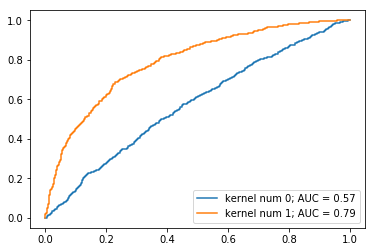

In [88]:
courbe_ROC([CCK([kernel1,kernel2],[1,1]), CCK([kernel1,kernel2],[0.8,0.05])], law_p, law_q, 1000,100,1000)

## Optimisation algorithm

In [77]:
def optimisation_GDA(Kernels, law_p, law_q, m=1000, n=100, alpha=0.05,
                     tr=0.01, tru=0.9, epsilon=1e-5, verbose=1):
    #Initialisation:
    Sden = cov_OMMD_MC(Kernels, law_p, law_q, verbose = 0)
    Snum = cov_OMMD_MC(Kernels, law_p, law_p, verbose = 0)
    Moy = np.r_[[moyenneMMD_MC(OMMD, kernel, law_p, law_q, 1000, 100, verbose=0) for kernel in Kernels]].reshape(-1,1)
    
    beta_new = np.ones((len(Kernels),1))
    beta = np.zeros((len(Kernels),1))
    while np.linalg.norm(beta_new-beta)/(np.linalg.norm(beta)+epsilon)>epsilon:
        beta = beta_new
        beta_new = next_step(beta, Snum, Sden, Moy, tr=tr, alpha=alpha,m=m)
        tr *= tru
    return beta_new

In [103]:
optimisation_GDA([kernel1,kernel1], law_p, law_q)

array([[0.36222641],
       [0.37736506]])

In [104]:
optimisation_GDA([kernel1,kernel2], law_p, law_q)

array([[ 0.8163575 ],
       [-0.04579811]])

In [105]:
optimisation_GDA([kernel2,kernel1], law_p, law_q)

array([[-0.04692922],
       [ 0.81321954]])

In [106]:
optimisation_GDA([kernel1,kernel1,kernel2], law_p, law_q)

array([[ 0.38335789],
       [ 0.38475667],
       [-0.04119185]])

### Experience

In [107]:
law_p = normal(0,1)
law_q = normal(0.5,np.sqrt(.75))
kernel1 = gaussian(1)
kernel2 = polynomial(0,2)

In [108]:
optimisation_GDA([kernel1,kernel1,kernel2], law_p, law_q)

array([[ 0.39238125],
       [ 0.40200729],
       [-0.03045618]])

In [116]:
law_p = normal(0,1)
law_q = normal(0.5,np.sqrt(.75))
kernel1 = gaussian(1)
kernel2 = polynomial(0,1)
optimisation_GDA([kernel2, kernel1,kernel2], law_p, law_q)

array([[-0.14838133],
       [ 0.53135326],
       [ 0.20201292]])

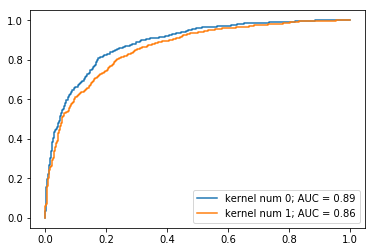

In [117]:
courbe_ROC([CCK([kernel2, kernel1,kernel2],[1,1,1]), 
            CCK([kernel2,kernel1,kernel2],[-0.15,0.53,0.2])], law_p, law_q, 1000,100,1000)

In [7]:
law_p = normal(0,1)
law_q = normal(1,1)
kernel1 = gaussian(10)
kernel2 = gaussian(1)
kernel3 = gaussian(0.1)
optimisation_GDA([kernel1, kernel2,kernel3], law_p, law_q)

array([[0.27939903],
       [0.33579252],
       [0.17482276]])

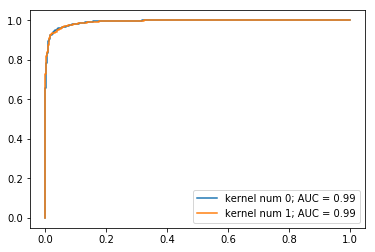

In [125]:
courbe_ROC([CCK([kernel1, kernel2,kernel3],[1,1,1]), 
            CCK([kernel1,kernel2,kernel3],[0.285,0.33,0.2])], law_p, law_q, 1000,100,1000)

In [10]:
thresh = threshold_MC(CCK([kernel1, kernel2,kernel3],[1,1,1]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel2,kernel3],[1,1,1]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé


0.856

In [11]:
thresh = threshold_MC(CCK([kernel1, kernel2,kernel3],[0.285,0.33,0.2]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel2,kernel3],[0.285,0.33,0.2]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé


0.922

In [12]:
thresh = threshold_MC(CCK([kernel1, kernel2,kernel3],[0,0.33,0]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel2,kernel3],[0,0.33,0]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé


0.927

## Methodes des barrières

### code

In [5]:
from scipy import optimize

In [22]:
optimize.fmin_bfgs()

TypeError: fmin_bfgs() missing 2 required positional arguments: 'f' and 'x0'

In [6]:
def penalite(beta, rho, Moy, Snum, Sden):
    beta = beta.reshape((-1,1))
    return (np.sqrt(beta.T.dot(Snum).dot(beta))*inv_phi(1-alpha) 
            - np.sqrt(m)*Moy.T.dot(beta) 
            + 1/(2*rho)*(beta.T.dot(Sden).dot(beta)-1)**2).flatten()

In [35]:
def Dpen(beta, rho, Moy, Snum, Sden):
    beta = beta.reshape((-1,1))
    return (Snum.dot(beta)/np.sqrt(beta.T.dot(Snum).dot(beta))*inv_phi(1-alpha) 
            - np.sqrt(m/2)*Moy
           + 1/rho*(beta.T.dot(Sden).dot(beta)-1)*Sden.dot(beta)).flatten()

In [1]:
def optim_p(penalite, Dpen, x0, methode,Moy, Snum, Sden, eps=1e-5):
    x_old = x0
    rho = 0.00001
    x = methode(lambda x: penalite(x, rho, Moy, Snum, Sden), x_old,
                fprime = lambda x: Dpen(x, rho, Moy, Snum, Sden))
    while np.linalg.norm(x_old - x) > eps:
        print("j")
        x_old = x
        rho *= 0.9
        x = methode(lambda x: penalite(x, rho, Moy, Snum, Sden), x_old,
                    fprime = lambda x: Dpen(x, rho, Moy, Snum, Sden))
    return x

In [2]:
def AlgOptBar(Kernels, law_p, law_q, m=1000, n=100, alpha=0.05):
    #Initialisation:
    Sden = cov_OMMD_MC(Kernels, law_p, law_q, finalSampleSize=10000, verbose = 0)
    Snum = cov_OMMD_MC(Kernels, law_p, law_p,finalSampleSize=10000, verbose = 0)
    Moy = np.r_[[moyenneMMD_MC(OMMD, kernel, law_p, law_q, 1000, 100,repeat=1000, verbose=0) for kernel in Kernels]].reshape(-1,1)
    
    beta = np.ones(len(Kernels))
    beta_optim = optim_p(penalite, Dpen, beta, optimize.fmin_bfgs,Moy, Snum, Sden)
    beta_optim = beta_optim/np.sum(beta_optim)
    
    return beta_optim

### Validation

In [14]:
law_p = normal(0,1)
law_q = normal(0.5,np.sqrt(.75))
kernel1 = gaussian(1)
kernel2 = polynomial(0,2)
Sden = cov_OMMD_MC([kernel1, kernel2], law_p, law_q, verbose = 0)
Snum = cov_OMMD_MC([kernel1, kernel2], law_p, law_p, verbose = 0)
Moy = np.r_[moyenneMMD_MC(OMMD, kernel1, law_p, law_q, 1000, 100, verbose=0),
           moyenneMMD_MC(OMMD, kernel2, law_p, law_q, 1000, 100, verbose=0)].reshape(-1,1)
alpha = 0.05
m = 1000
beta = np.ones((2,1))

In [30]:
beta_optim = optim_p(penalite, Dpen, beta, optimize.fmin_bfgs, eps=1e-5)
beta_optim = beta_optim/np.linalg.norm(beta_optim)
beta_optim

TypeError: optim_p() missing 3 required positional arguments: 'Moy', 'Snum', and 'Sden'

In [63]:
thresh = threshold_MC(CCK([kernel1, kernel2],[1,1]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel2],[1,1]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé


0.017

In [64]:
thresh = threshold_MC(CCK([kernel1, kernel2],[0.9999,0.01]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel2],[0.9999,0.01]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé


0.197

In [65]:
thresh = threshold_MC(kernel1, law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD,kernel1, law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé


0.203

In [73]:
AlgOptBar([kernel1, kernel2], law_p, law_q, m=1000, n=100, alpha=0.05)

         Current function value: 49985.032772
         Iterations: 8
         Function evaluations: 44
         Gradient evaluations: 33
j
         Current function value: 499843.978207
         Iterations: 0
         Function evaluations: 102
         Gradient evaluations: 90


array([0.98772082, 0.01227918])

### Experiments

In [10]:
law_p = normal(0,1)
law_q = normal(1,1)
kernel1 = gaussian(10)
kernel2 = gaussian(1)
kernel3 = gaussian(0.1)

In [15]:
optimisation_GDA([kernel1, kernel3], law_p, law_q)

NameError: name 'optimisation_GDA' is not defined

In [16]:
AlgOptBar([kernel1, kernel3], law_p, law_q, m=1000, n=100, alpha=0.05)

         Current function value: 0.001686
         Iterations: 6
         Function evaluations: 95
         Gradient evaluations: 83
j
         Current function value: 0.001687
         Iterations: 0
         Function evaluations: 99
         Gradient evaluations: 87


array([ 1.36283736, -0.36283736])

In [92]:
thresh = threshold_MC(CCK([kernel1, kernel3],[1,1]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel3],[1,1]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé


0.785

In [90]:
thresh = threshold_MC(CCK([kernel1, kernel3],[0.03,0.97]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel3],[0.03,0.97]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé


0.415

In [91]:
thresh = threshold_MC(CCK([kernel1, kernel3],[0.97,0.03]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel3],[0.97,0.03]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componantevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé


0.995

In [94]:
thresh = threshold_MC(CCK([kernel1, kernel3],[0.61,0.47]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel3],[0.61,0.47]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé


0.821

In [12]:
AlgOptBar([kernel1, kernel2, kernel3], law_p, law_q, m=1000, n=100, alpha=0.05)

NameError: name 'alpha' is not defined

In [39]:
thresh = threshold_MC(CCK([kernel1, kernel2, kernel3],[1.06812572, -0.07928149,0.01115577]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel2, kernel3],[1.06812572, -0.07928149,0.01115577]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé% achevé % achevé % achevé % achevé


0.999

In [40]:
thresh = threshold_MC(CCK([kernel1, kernel2, kernel3],[0.5, 0.4, 0.1]), law_p, law_p, m=1000, n=100, alpha=0.05)
puissance_MC(OMMD, CCK([kernel1, kernel2, kernel3],[0.5, 0.4, 0.1]), law_p, law_q,1000,100,thresh)

Start computing first componant
Start computing second componanthevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé % achevé


0.993

It seem not perform well, mayby, there is a local minimum ?

In [103]:
M = np.zeros((10,10))
for j in range(10):
    for i in range(10-j):
        rho1 = 0.1*j
        rho2 = 0.1*i
        rho3 = 1-rho1 - rho2
        print(i,j)
        thresh = threshold_MC(CCK([kernel1, kernel2, kernel3],[rho1,rho2,rho3]), law_p, law_p, m=1000, n=100, alpha=0.05,verbose=0)
        M[j,i] = puissance_MC(OMMD, CCK([kernel1, kernel2, kernel3],[rho1,rho2,rho3]), law_p, law_q,1000,100,thresh)

0 0
1 09 % achevé9999 % achevéé
2 09 % achevé9999 % achevéé % achevé % achevé
3 09 % achevé9999 % achevéé
4 09 % achevé9999 % achevéé % achevé % achevé % achevé% achevé
5 09 % achevé9999 % achevéé % achevé % achevé % achevé % achevé % achevé % achevé% achevé% achevé % achevé
6 09 % achevé9999 % achevéé % achevé % achevé% achevé % achevé
7 09 % achevé9999 % achevéé % achevé % achevé % achevé % achevé % achevé% achevé% achevé
8 09 % achevé9999 % achevéé % achevé % achevé
9 09 % achevé9999 % achevéé
0 19 % achevé9999 % achevéé
1 19 % achevé9999 % achevéé
2 19 % achevé9999 % achevéé
3 19 % achevé9999 % achevéé
4 19 % achevé9999 % achevéé
5 19 % achevé9999 % achevéé% achevé
6 19 % achevé9999 % achevéé
7 19 % achevé9999 % achevéé % achevé % achevé % achevé
8 19 % achevé9999 % achevéé
0 29 % achevé9999 % achevéé
1 29 % achevé9999 % achevéé % achevé % achevé % achevé
2 29 % achevé9999 % achevéé % achevé % achevé
3 29 % achevé9999 % achevéé
4 29 % achevé9999 % achevéé
5 29 % achevé9999 % achevé

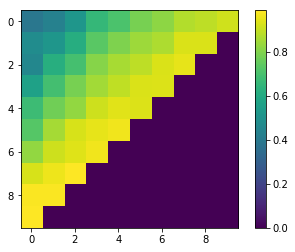

In [105]:
plt.imshow(M)
plt.colorbar()

In [27]:
sigma1 = 1.21
mu1 = 0.2
sigma2 = 1
mu2 = 0
omega = 0.1
omega1 = 0.01
omega2 = 20
law_p = normal(mu1,sigma1)
law_q = normal(mu2,sigma2)
kernel1 = gaussian(omega1**2)
kernel2 = gaussian(omega2**2)
alpha = 0.3
m=1000
n=100


In [28]:
AlgOptBar([kernel1, kernel2], law_p, law_q, m=1000, n=100, alpha=0.3)

         Current function value: 0.359868
         Iterations: 71
         Function evaluations: 203
         Gradient evaluations: 191
j
         Current function value: 0.359868
         Iterations: 3
         Function evaluations: 70
         Gradient evaluations: 58
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         

Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
j
Optimization terminated successfully.
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 3
         

         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 95
         Gradient evaluations: 83
j
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 88
         Gradient evaluations: 76
j
         Current function value: 0.359868
         Iterations: 1
         Function evaluations: 90
         Gradient evaluations: 78
j
         Current function value: 0.359868
         Iterations: 0
         Function evaluations: 90
         Gradient evaluations: 78


array([0.10630977, 0.89369023])

In [46]:
sigma1 = 1.1
mu1 = .2
sigma2 = 1
mu2 = 0
omega = 0.01
omega1 = 0.01
omega2 = 20
law_p = normal(mu1,sigma1)
law_q = normal(mu2,sigma2)
kernel1 = gaussian(omega1**2)
kernel2 = gaussian(omega2**2)
alpha = 0.05
m=1000
n=100

In [48]:
AlgOptBar([kernel1, kernel2], law_p, law_q, m=1000, n=100, alpha=0.05)

         Current function value: 1.578101
         Iterations: 81
         Function evaluations: 159
         Gradient evaluations: 149
j
         Current function value: 1.578100
         Iterations: 1
         Function evaluations: 110
         Gradient evaluations: 98
j
         Current function value: 1.578102
         Iterations: 1
         Function evaluations: 89
         Gradient evaluations: 78


array([0.11545959, 0.88454041])

In [38]:
thresh = threshold_MC(CCK([kernel1, kernel2],[0.003,0.997]), law_p, law_p, m=1000, n=100, alpha=0.05,verbose=0)
puissance_MC(OMMD, CCK([kernel1, kernel2],[0.003,0.997]), law_p, law_q,1000,100,thresh)

1.0

In [39]:
thresh = threshold_MC(CCK([kernel1, kernel2],[0.997,0.003]), law_p, law_p, m=1000, n=100, alpha=0.05,verbose=0)
puissance_MC(OMMD, CCK([kernel1, kernel2],[0.997,0.003]), law_p, law_q,1000,100,thresh)

0.226